In [ ]:
# torch and torchvision imports
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### (a) Plot the training and validation losses and errors as a function of the number of epochs


 The model currently does not achieve less than 12% validation error, you have to tweak the parameters to get it.

In [ ]:
# Reading in the dataset
transform_train = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.RandomRotation(15),
     transforms.RandomCrop(32, padding=4),
     transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation = 0.3, hue = 0.3),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                          shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=16,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


# Defining the model
class View(nn.Module):
    def __init__(self,o):
        super().__init__()
        self.o = o

    def forward(self,x):
        return x.view(-1, self.o)

class allcnn_t(nn.Module):
    def __init__(self, c1=96, c2= 192):
        super().__init__()
        d = 0.5

        def convbn(ci,co,ksz,s=1,pz=0):
            return nn.Sequential(
                nn.Conv2d(ci,co,ksz,stride=s,padding=pz),
                nn.ReLU(True),
                nn.BatchNorm2d(co))

        self.m = nn.Sequential(
            nn.Dropout(0.2),
            convbn(3,c1,3,1,1),
            convbn(c1,c1,3,1,1),
            convbn(c1,c1,3,2,1),
            nn.Dropout(d),
            convbn(c1,c2,3,1,1),
            convbn(c2,c2,3,1,1),
            convbn(c2,c2,3,2,1),
            nn.Dropout(d),
            convbn(c2,c2,3,1,1),
            convbn(c2,c2,3,1,1),
            convbn(c2,10,1,1),
            nn.AvgPool2d(8),
            View(10))

        print('Num parameters: ', sum([p.numel() for p in self.m.parameters()]))

    def forward(self, x):
        return self.m(x)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# The training loop
logger = SummaryWriter()

def train(net, optimizer, criterion, train_loader, test_loader, epochs, model_name, plot):
    model = net.to(device)
    total_step = len(train_loader)
    overall_step = 0
    train_loss_values = []
    train_error = []
    val_loss_values = []
    val_error = []
    for epoch in range(epochs):
        correct = 0
        total = 0
        flag = 0
        running_loss = 0.0
        if epoch == 40 and flag == 0:
          for op_params in optimizer.param_groups:
            op_params['lr'] = 0.01
          flag = 1
        if epoch == 80 and flag == 0:
          for op_params in optimizer.param_groups:
            op_params['lr'] = 0.001
          flag = 1
        for i, (images, labels) in enumerate(train_loader):
            # Move tensors to configured device
            images = images.to(device)
            labels = labels.to(device)
            #Forward Pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            optimizer.step()
            if (i+1) % 1000 == 0:
              print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, epochs, i+1, total_step, loss.item()))
            if plot:
              info = { ('loss_' + model_name): loss.item() }

              for tag, value in info.items():
                logger.add_scalar(tag, value, overall_step+1)
        train_loss_values.append(running_loss)
        train_error.append(100-100*correct/total)

        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for i, (images, labels) in enumerate(test_loader):
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        print('Accuracy of the network on the test images: {} %'.format(100 * correct / total))
        val_error.append(100-100*correct/total)
        val_loss_values.append(running_loss)
    return val_error,val_loss_values,train_error,train_loss_values


In [ ]:
model = allcnn_t().to(device)
epochs = 100
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001, nesterov=True)
val_error,val_loss_values,train_error,train_loss_values= train(model, optimizer, criterion, trainloader, testloader, epochs, 'cnn_curve', True)

Num parameters:  1667166
Epoch [1/100], Step [1000/3125], Loss: 2.1037
Epoch [1/100], Step [2000/3125], Loss: 1.5825
Epoch [1/100], Step [3000/3125], Loss: 1.8452
Accuracy of the network on the test images: 42.03 %
Epoch [2/100], Step [1000/3125], Loss: 1.2997
Epoch [2/100], Step [2000/3125], Loss: 0.8745
Epoch [2/100], Step [3000/3125], Loss: 1.2265
Accuracy of the network on the test images: 59.82 %
Epoch [3/100], Step [1000/3125], Loss: 1.7331
Epoch [3/100], Step [2000/3125], Loss: 1.8891
Epoch [3/100], Step [3000/3125], Loss: 1.0696
Accuracy of the network on the test images: 64.81 %
Epoch [4/100], Step [1000/3125], Loss: 1.1752
Epoch [4/100], Step [2000/3125], Loss: 1.1936
Epoch [4/100], Step [3000/3125], Loss: 1.0858
Accuracy of the network on the test images: 66.01 %
Epoch [5/100], Step [1000/3125], Loss: 1.3464
Epoch [5/100], Step [2000/3125], Loss: 0.9536
Epoch [5/100], Step [3000/3125], Loss: 1.2591
Accuracy of the network on the test images: 73.07 %
Epoch [6/100], Step [1000

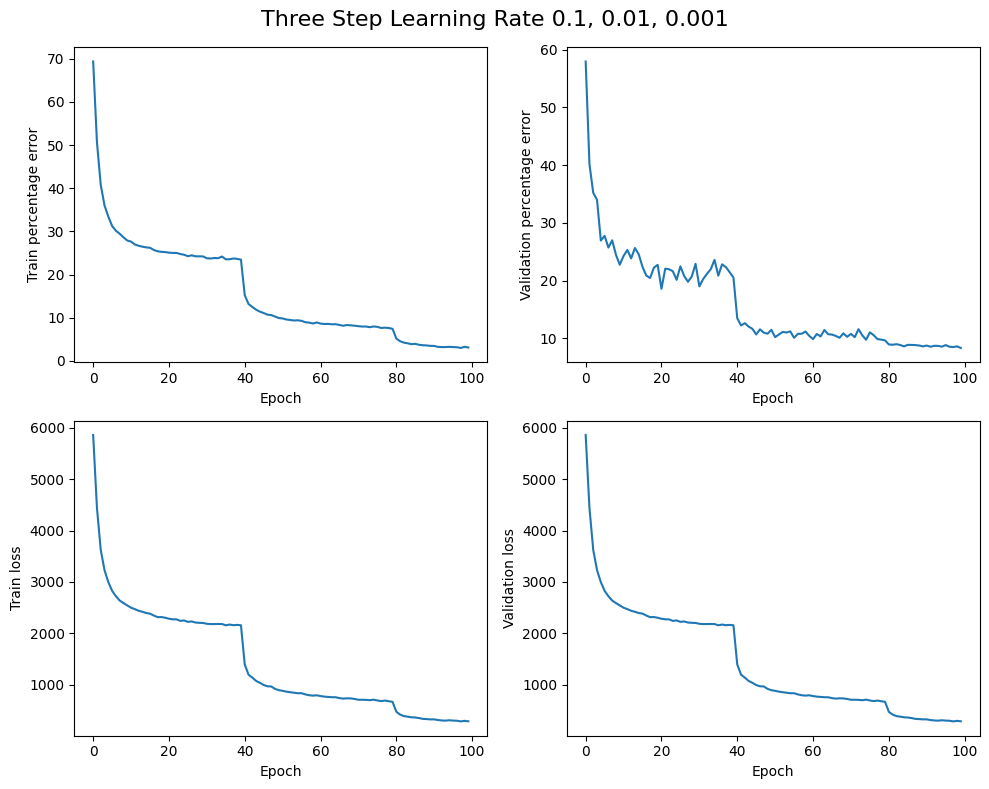

In [ ]:
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
plt.plot(train_error)
plt.xlabel('Epoch')
plt.ylabel('Train percentage error')

plt.subplot(2, 2, 2)
plt.plot(val_error)
plt.xlabel('Epoch')
plt.ylabel('Validation percentage error')

plt.subplot(2, 2, 3)
plt.plot(train_loss_values)
plt.xlabel('Epoch')
plt.ylabel('Train loss')

plt.subplot(2, 2, 4)
plt.plot(val_loss_values)
plt.xlabel('Epoch')
plt.ylabel('Validation loss')

plt.suptitle('Three Step Learning Rate 0.1, 0.01, 0.001', fontsize=16)

plt.tight_layout()
plt.show()

## (b)

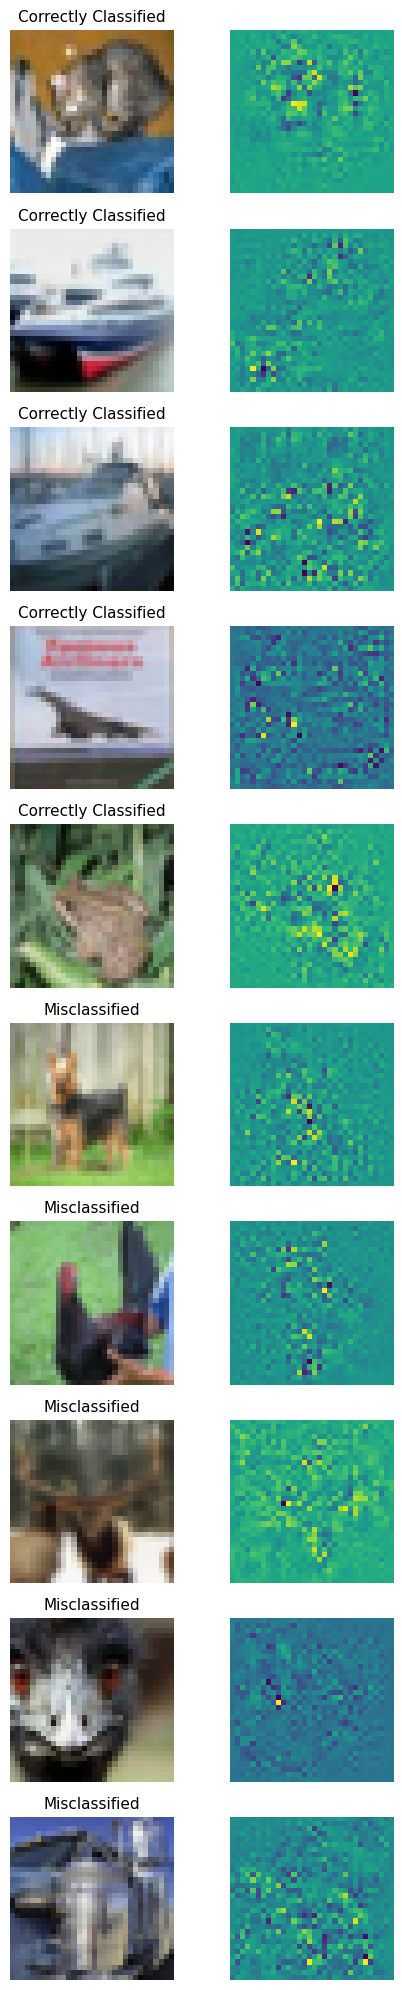

In [ ]:
import numpy as np

model.eval()
correct = 0
misclassified = 0
count = 0
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False)
criterion = nn.CrossEntropyLoss()
fig, axes = plt.subplots(10, 2, figsize=(5, 20))
for i, (images, labels) in enumerate(testloader):
    if correct == 5 and misclassified == 5:
        break

    images = images.to(device)
    labels = labels.to(device)
    model.zero_grad()
    images.requires_grad = True
    outputs = model(images)

    _, predicted = torch.max(outputs.data, 1)
    true_label = labels.item()
    predicted_label = predicted.item()

    loss_value = criterion(outputs, labels)
    loss_value.backward()
    dx = images.grad.data.clone()

    if true_label == predicted_label and correct < 5:
        correct += 1
        axes[count,0].set_title("Correctly Classified",fontsize=11)
        axes[count,0].imshow(testloader.dataset.data[i])
        axes[count,0].axis('off')
        axes[count,1].imshow(dx[0, 0].cpu().numpy())
        axes[count,1].axis('off')
        count += 1

    elif true_label != predicted_label and misclassified < 5:
        misclassified +=1
        axes[count,0].set_title("Misclassified",fontsize=11)
        axes[count,0].imshow(testloader.dataset.data[i])
        axes[count,0].axis('off')
        axes[count,1].imshow(dx[0, 0].cpu().numpy())
        axes[count,1].axis('off')
        count += 1

plt.tight_layout()
plt.show()

Attack: 0 Loss: 26.071471787398877
Attack: 1 Loss: 729.0464175042339
Attack: 2 Loss: 2024.1798526755156
Attack: 3 Loss: 3140.412542819977
Attack: 4 Loss: 4090.678213119507


Text(0, 0.5, 'Loss')

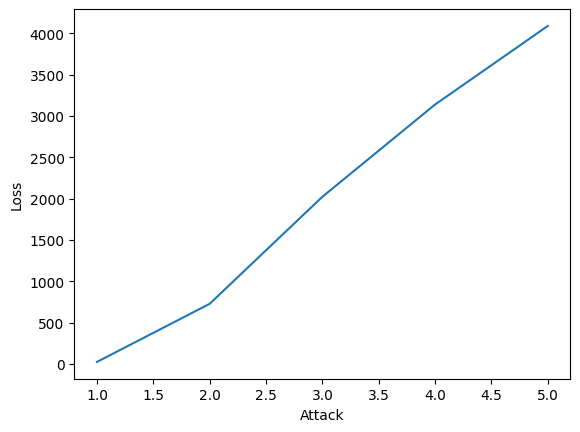

In [ ]:
dataloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False)
iterator = iter(dataloader)
x_batch, y_batch = next(iterator)
eps = 8/255
loss = []
for k in range(5):
  l = 0
  for i in range(len(x_batch)):
    image = x_batch[i].unsqueeze(0).to(device)
    label = y_batch[i].unsqueeze(0).to(device)
    image = nn.Parameter(image, requires_grad = True)
    output = model(image)
    loss_value = criterion(output, label)
    loss_value.backward()
    l += loss_value.item()
    dx = image.grad.data.clone()
    x_batch[i] = image[0] + torch.sign(dx)*eps
  loss.append(l)
  print("Attack: {} Loss: {}".format(k,l))

plt.plot(range(1,6), loss)
plt.xlabel('Attack')
plt.ylabel('Loss')

## (c)

In [ ]:

testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False)

eps = 8/255
correct = 0
total = 0
with torch.no_grad():
  for i, (images, labels) in enumerate(testloader):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network before attack: {} %'.format(100 * correct / total))


correct = 0
total = 0
images = []
labels = []
for i, (image, label) in enumerate(testloader):
    images.append(image)
    labels.append(label)

n = len(images)

for i in range(n):
    image = images[i].to(device)
    label = labels[i].to(device)
    model.zero_grad()
    image = nn.Parameter(image, requires_grad = True)
    output = model(image)
    loss_value = criterion(output, label)
    loss_value.backward()
    dx = image.grad.data.clone()
    images[i] = image + torch.sign(dx)*eps

with torch.no_grad():
  for i in range(n):
    image = images[i].to(device)
    label = labels[i].to(device)
    output = model(image)
    _, predicted = torch.max(output.data, 1)
    total += label.size(0)
    correct += (predicted == label).sum().item()

print("Accuracy of the network after attack: {}%".format(100*correct/total))

Accuracy of the network before attack: 91.7 %
Accuracy of the network after attack: 25.64%
